# Single Dish Calibration Tutorial

### In this tutorial, we will calibrate raw SDFITS (Single-Dish FITS) files from the GBT utilizing On/Off observations of a calibration point source with a known flux. The observing set up of the spectral line science observations of UGC4278 are unique in that they were taken in a frequency-switching mode are calibrated for imaging like position-switched data. Our reference spectrum is built from the first and last four integerations from each column/row of the on-the-fly map. The imaging will be performed with CASA.

The general steps to take the data from their raw format to final image cube are:
(1) - determine the Tcal factor from the calibrator observations (i.e., the scaling factor to apply to our final spectra)
(2) - for each row/column in our on-the-fly map, construct a reference spectrum from the first and last four integrations (for a total of 8)
(3) - correct for atmospheric attenuation based on the recorded Elevation of the telescope.
(4) - fit a reasonable polynomial across each bandpass to remove residual baseline variations
(5) - read in the calibrated SDFITS file to CASA for imaging


In [1]:
## imports
from astropy.io import fits 
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from scipy.optimize import curve_fit
from scipy.interpolate import *
import matplotlib.pyplot as pyplot
from matplotlib.patches import Ellipse
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib
%matplotlib inline
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 
matplotlib.rc('xtick.major.width')
matplotlib.rcParams['contour.negative_linestyle']= 'solid'
matplotlib.rcParams.update({'font.size': 14})
# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib 
# accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [20]:
## read in SDFITS file
hdu = fits.open('AGBT13B_406_01.raw.acs.fits')

## get to know the structure of the file by looking at the various tables
print(hdu.info())

Filename: AGBT13B_406_01.raw.acs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   ()      
  1  SINGLE DISH    1 BinTableHDU    229   1536R x 70C   [32A, 1D, 22A, 1D, 1D, 1D, 4096E, 16A, 6A, 8A, 1D, 1D, 1D, 4A, 1D, 4A, 1D, 1I, 32A, 32A, 1J, 32A, 16A, 1E, 8A, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 8A, 1D, 1D, 12A, 1I, 1I, 1D, 1D, 1I, 1A, 1I, 1I, 16A, 16A, 1J, 1J, 22A, 1D, 1D, 1I, 1A, 1D, 1E, 1D, 1A, 1A, 8A, 1E, 1E, 16A, 1I, 1I, 1I]   
  2  SINGLE DISH    1 BinTableHDU    229   152256R x 70C   [32A, 1D, 22A, 1D, 1D, 1D, 8192E, 16A, 6A, 8A, 1D, 1D, 1D, 4A, 1D, 4A, 1D, 1I, 32A, 32A, 1J, 32A, 16A, 1E, 8A, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 8A, 1D, 1D, 12A, 1I, 1I, 1D, 1D, 1I, 1A, 1I, 1I, 16A, 16A, 1J, 1J, 22A, 1D, 1D, 1I, 1A, 1D, 1E, 1D, 1A, 1A, 8A, 1E, 1E, 16A, 1I, 1I, 1I]   
None


#### we see there are 3 total FITS binary tables. The first is the primary header of the file that just tells us basic information such as which telescope generated this file. Let's see what the other two tables are storing. 

In [21]:
print(hdu[1].header)
print(hdu[2].header)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / 8-bit bytes                                    NAXIS   =                    2 / 2-dimensional binary table                     NAXIS1  =                16978 / width of table in bytes                        NAXIS2  =                 1536 / number of rows in table                        PCOUNT  =                    0 / size of special data area                      GCOUNT  =                    1 / one data group (required keyword)              TFIELDS =                   70 / number of fields in each row                   COMMENT Start of SDFITS CORE keywords/columns.                                  TTYPE1  = 'OBJECT  '           / name of source observed                        TFORM1  = '32A     '                                                            TUNIT1  = '        '                                                            TELESCOP= 'NRAO_GBT'           / the tel

#### okay, that's A LOT of information (referred generally as 'meta-data'). One of the first entries (or parameters) in the table is called 'OBJECT'. Let's see what was observed by taking a look at the OBJECT column of the last two tables. Note that some parameters have explicty units associated with them.

In [22]:
print(hdu[1].data['OBJECT'])
print(hdu[2].data['OBJECT'])

['3C147' '3C147' '3C147' ..., '3C147' '3C147' '3C147']
['UGC4278' 'UGC4278' 'UGC4278' ..., 'NGC4565' 'NGC4565' 'NGC4565']


#### we see that they are different. The first table contains data for the calibration source 3C295, while the second contains data for our science target. Are the columns different lengths?

In [23]:
objCol_CalSrc = hdu[1].data['OBJECT'] ## these will be returned as numpy arrays
objCol_SciSrc = hdu[2].data['OBJECT']
print(objCol_CalSrc.shape)
print(objCol_SciSrc.shape)

(1536,)
(152256,)


#### The science target columns contains many more rows. Take a few more minutes exploring the shapes of other columns (e.g., the AZIMUTH, ELEVATIO, or anything else that looks interesting). How do the shape of the column contains the actual data (DATA) compare?

In [24]:
dataCol_CalSrc = hdu[1].data['DATA']
dataCol_SciSrc = hdu[2].data['DATA']
print(dataCol_CalSrc.shape)
print(dataCol_SciSrc.shape)

(1536, 4096)
(152256, 8192)


## these are very different! Why? Let's chat more about how these observations are set up...
The two bandpass settings are optimized for calibration and science. The calibration bandpass consists of 4096 channels with a spectral resolution of 12.207 kHz (you can check the values of the parameter CDELT1), which span a total bandwidth of 50 MHz. The broad spectral range is necessary to ensure an accurate measurement of the system temperature. The bandpass for the science target has much finer resolution in order to resolve the HI line and thus spans a shorter range of frequencies. 

The data columns holding the actual arrays are structured such that the rows (0-th element) contain the time samples (or integrations) and the columns (2nd element) contain the raw system response (i.e., in 'counts')in each spectral channel.

The calibration observations were taken in the form of off/on with a total of 12 integrations per scan, 8 spectral windows, 2 phases (diode On, diode Off, 2 polarizations (12x8x2x2 = 384). A spectral window refers to a 50 MHz band with a different central frequency. Since we are most intersted in the HI line, let's pick out the indices where 'IFNUM' equals 0. Then pick out the the CalOn and CalOff & polarizations knowing the element order of the noise diode firing (CAL state is T/F and polarizaiton order is XX XX YY YY). 

In [25]:
ifData = hdu[1].data['IFNUM']
ifInds = np.where(ifData == 0) ## will return indices that match condition 
calData = hdu[1].data['CAL'] ## ordered On/Off
polData = hdu[1].data['PLNUM'] ## ordered XX (CalOn) XX (CalOff) YY (CalOn) YY (CalOff)
newDataCol_CalSrc = dataCol_CalSrc[ifInds, :][0]
polData = polData[ifInds] ## select relevant rows

data_CalOn = newDataCol_CalSrc[0::2, :] ## select all CAL_ON integrations
data_CalOff = newDataCol_CalSrc[1::2, :] ## seleect all CAL_OFF integrations

data_CalOn_XX = data_CalOn[0::2, :]
data_CalOn_YY = data_CalOn[1::2, :]
data_CalOff_XX = data_CalOff[0::2, :]
data_CalOff_YY = data_CalOff[1::2, :]

#### Equation for Tcal = (S_src * eta * A_p)/k*((P_ref,on - P_ref,off/(P_sig,off - P_ref,off))
Average each 12 integration chunk of the sorted data arrays and compute Tcal as a function of channel. Take mean of channels near HI line for the final Tcal value for each polarization

In [26]:
## method to compute tcal, assuming observed calibrator source of 3C295
def computeTcal(P_refOn, P_refOff, PsigOff):
    S_calSrc = 21.2*1e-26 ## Jy
    A_p = (100/2)**2*np.pi
    eta = 0.65
    k = 1.38064852e-23 ##m2 kg s-2 K-1
    tcalBandpass = (S_calSrc*A_p*eta)/(2*k)*((P_refOn - P_refOff)/(PsigOff - P_refOff))
    ## take mean near channels around 1.420 GHz
    return np.mean(tcalBandpass[2048-20:2048+20])
    

for i in range(0, int(data_CalOn_XX.shape[0]/12)):
    if i % 2 == 0: ## if mean scan number, then we have a reference scan (procedure was OFF then ON)
        intChunk_Start = i*12 ## grab next chunk of 12 integrations
        intChunk_End = intChunk_Start + 12
        mean_CalOn_XX_REF = np.mean(data_CalOn_XX[intChunk_Start:intChunk_End,:], axis = 0)
        mean_CalOn_YY_REF = np.mean(data_CalOn_YY[intChunk_Start:intChunk_End,:], axis = 0)
        mean_CalOff_XX_REF = np.mean(data_CalOff_XX[intChunk_Start:intChunk_End,:], axis = 0)
        mean_CalOff_YY_REF = np.mean(data_CalOff_YY[intChunk_Start:intChunk_End,:], axis = 0)
    else:
        intChunk_Start = i*12 ## grab next chunk of 12 integrations
        intChunk_End = intChunk_Start + 12
        mean_CalOn_XX_SIG = np.mean(data_CalOn_XX[intChunk_Start:intChunk_End,:], axis = 0)
        mean_CalOn_YY_SIG = np.mean(data_CalOn_YY[intChunk_Start:intChunk_End,:], axis = 0)
        mean_CalOff_XX_SIG = np.mean(data_CalOff_XX[intChunk_Start:intChunk_End,:], axis = 0)
        mean_CalOff_YY_SIG =np.mean(data_CalOff_YY[intChunk_Start:intChunk_End,:], axis = 0)
    if i == 1 or i == 3:
        tCal_XX = computeTcal(mean_CalOn_XX_REF,  mean_CalOff_XX_REF, mean_CalOff_XX_SIG)
        print('T_cal (XX): %.2f' % tCal_XX)
        tCal_YY = computeTcal(mean_CalOn_YY_REF,  mean_CalOff_YY_REF, mean_CalOff_YY_SIG)
        print('T_cal (YY): %.2f' % tCal_YY)
        

T_cal (XX): 1.63
T_cal (YY): 1.60
T_cal (XX): 1.64
T_cal (YY): 1.63


#### Now that we have are scaling factors derived, let's get to work on calibrating the science observations. 

These were taken in frequency switching mode, although we calibrate them as if they were position switched. The equation used is T_A = tcal*(on- <off>)/(<calonon>-<caloff>), where brackets denote time averages. The ‘off’ values are calculated using four integrations from each edge of the map for a total of eight ‘off’ integrations to increase
the signal-to-noise. Using the edge of the map as a reference position is an advantage because we are able to obtain a reference spectrum for each RA/Dec scan without sacrificing telescope time to slew off source. 

Our GBT maps were made in a “basket-weave” (or raster) fashion by scanning the telescope for 2◦/3◦ along constant lines of right ascension and declination to stitch together a final 4 deg2 (9 deg2 for NGC925) image (Mangum et al. 2007). Each row or column is offset by 3′, and each scan consisted of a total of 72 separate 5 s integrations that were dumped every 100′′ to ensure Nyquist sampling.

1407968828.48


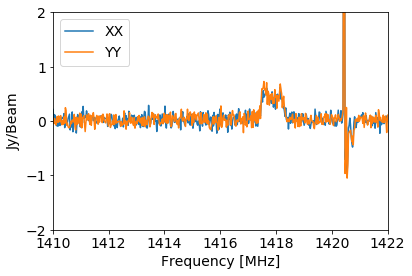

In [74]:
## method to compute reference spectrum
def computeRefSpectrum(dataTable):
    ## initialize arrays for time averaging
    powerCalOn_Sig_XX = np.zeros([8, dataTable.shape[1]])
    powerCalOn_Sig_YY = np.zeros([8, dataTable.shape[1]])
    powerCalOff_Sig_XX = np.zeros([8, dataTable.shape[1]])
    powerCalOff_Sig_YY = np.zeros([8, dataTable.shape[1]])
    powerCalOn_Ref_XX = np.zeros([8, dataTable.shape[1]])
    powerCalOn_Ref_YY = np.zeros([8, dataTable.shape[1]])
    powerCalOff_Ref_XX = np.zeros([8, dataTable.shape[1]])
    powerCalOff_Ref_YY = np.zeros([8, dataTable.shape[1]])
    
    ## loop through the total number of integrations and select the 8-row chunks to 
    ## build reference spectrum
    for intNum in range(0, 8):
        if intNum < 4: ## select first 4 integraions
            intChunk_Start = intNum*8 
            intChunk_End = intChunk_Start + 8
        else:
            intChunk_Start = (72*8-intNum*8) ## select last 4 integraions
            intChunk_End = intChunk_Start + 8
        intData = dataTable[intChunk_Start:intChunk_End, :] 
        #get calon for the off for sig=T
        powerCalOn_Sig_XX[intNum, :] = intData[7, :]
        powerCalOn_Sig_YY[intNum, :] = intData[3, : ]
        #get caloff for the off for sig=T
        powerCalOff_Sig_XX[intNum, :] = intData[6, :]
        powerCalOff_Sig_YY[intNum, :] = intData[2, :]
        #get calon for the off for sig=F
        powerCalOn_Ref_XX[intNum, :] = intData[5, :]
        powerCalOn_Ref_YY[intNum, :] = intData[1, :]
        #get caloff for the off for sig=F
        powerCalOff_Ref_XX[intNum, :] = intData[4, :]
        powerCalOff_Ref_YY[intNum, :] = intData[0, :]
        
    ## take time average
    powerCalOn_Sig_XX_Ave = np.mean(powerCalOn_Sig_XX, axis = 0)
    powerCalOn_Sig_YY_Ave = np.mean(powerCalOn_Sig_YY, axis = 0)
    powerCalOff_Sig_XX_Ave = np.mean(powerCalOff_Sig_XX, axis = 0)
    powerCalOff_Sig_YY_Ave = np.mean(powerCalOff_Sig_YY, axis = 0)
    powerCalOn_Ref_XX_Ave = np.mean(powerCalOn_Ref_XX, axis = 0)
    powerCalOn_Ref_YY_Ave = np.mean(powerCalOn_Ref_YY, axis = 0)
    powerCalOff_Ref_XX_Ave = np.mean(powerCalOff_Ref_XX, axis = 0)
    powerCalOff_Ref_YY_Ave = np.mean(powerCalOff_Ref_YY, axis = 0)
    
    ## <calOn - calOff> for signal freq
    powerCalDiff_Sig_XX = powerCalOn_Sig_XX_Ave - powerCalOff_Sig_XX_Ave
    powerCalDiff_Sig_YY = powerCalOn_Sig_XX_Ave - powerCalOff_Sig_XX_Ave   
    
    ## <calOn - calOff> for ref freq
    powerCalDiff_Ref_XX = powerCalOn_Ref_XX_Ave - powerCalOff_Ref_XX_Ave
    powerCalDiff_Ref_YY = powerCalOn_Ref_XX_Ave - powerCalOff_Ref_XX_Ave   
    
    ## <off> for signal freq
    off_Sig_XX = (powerCalOn_Sig_XX_Ave + powerCalOff_Sig_XX_Ave)/2
    off_Sig_YY = (powerCalOn_Sig_YY_Ave + powerCalOff_Sig_YY_Ave)/2
    
    ## <off> for ref freq
    off_Ref_XX = (powerCalOn_Ref_XX_Ave + powerCalOff_Ref_XX_Ave)/2
    off_Ref_YY = (powerCalOn_Ref_YY_Ave + powerCalOff_Ref_YY_Ave)/2
    
    return powerCalDiff_Sig_XX, powerCalDiff_Sig_YY, powerCalDiff_Ref_XX, powerCalDiff_Ref_YY, off_Sig_XX, off_Sig_YY, off_Ref_XX, off_Ref_YY
    
## method to average cal-on/cal-off states for 'On'
def computeOn(dataTable):      
    powerOn_Sig_XX = (dataTable[6, :] + dataTable[7, :])/2
    powerOn_Sig_YY = (dataTable[2, :] + dataTable[3, :])/2
    powerOn_Ref_XX = (dataTable[4, :] + dataTable[5, :])/2
    powerOn_Ref_YY = (dataTable[0, :] + dataTable[1, :])/2
    return powerOn_Sig_XX, powerOn_Sig_YY, powerOn_Ref_XX, powerOn_Ref_YY

## method to average calibrated reference
def fold(calibratedRef, calibratedSig):
    ## recall the order of the ref/sig phases is F T F T..., so take the difference between 0th and 1st elements
    refFreq = cenFreqs[0]
    sigFreq = cenFreqs[1]
    freqDiff = np.abs(cenFreqs[0] - cenFreqs[1])
    ## take ratio of different to determine number of channels to shift (to nearest integer)
    numChanShift = np.int(np.ceil(freqDiff/freqRes))
    calibratedSpectrum = np.copy(calibratedSig)
    calibratedSpectrum[numChanShift:] = (calibratedSig[numChanShift:] + calibratedRef[numChanShift:])/2
    return calibratedSpectrum
    
hdu = fits.open('AGBT13B_406_09.smoothed.fits')

## get necessary meta-data
cenFreqs = hdu[1].data['CRVAL1'] ## Hz
cenFreqChannels = hdu[1].data['CRPIX1']
freqRes = np.abs(hdu[1].data['CDELT1'][0]) ## Hz

dataTable = hdu[1].data['DATA']
scanTable = hdu[1].data['SCAN']
calTable = hdu[1].data['CAL']
sigTable = hdu[1].data['SIG']
polTable = hdu[1].data['PLNUM']
ifTable = hdu[1].data['IFNUM']
elTable = hdu[1].data['ELEVATIO']

## loop through each science scan. For each scan, first select the integrations the time average of the 
for i in range(10, 11):
    
    ## get indices to pull out rows corresponding to scan number from data table
    scanInds = np.where(scanTable == i)
    dataTable_sortedByScan = dataTable[scanInds, :][0]
    calTable_sortedByScan = calTable[scanInds]
    sigTable_sortedByScan = sigTable[scanInds]
    polTable_sortedByScan = polTable[scanInds] 
    ifTable_sortedByScan =  ifTable[scanInds]
    elTable_sortedByScan = elTable[scanInds]
    
    ## now, select rows corresponding to first spectral window
    ifInds = np.where(ifTable_sortedByScan == 0)
    dataTable_sortedByIF = dataTable_sortedByScan[ifInds, :][0]
    calTable_sortedByIF = calTable_sortedByScan[ifInds] ## order of CAL states (per integration): T T F F T T F F
    sigTable_sortedByIF = sigTable_sortedByScan[ifInds] ## order of SIG states (per integration): F T F T F T F T
    polTable_sortedByIF = polTable_sortedByScan[ifInds] ## order of POL sates (per integration): XX XX XX XX YY YY YY YY
    ifTable_sortedByIF = ifTable_sortedByScan[ifInds]
    elTable_sortedByIF = elTable_sortedByScan[ifInds]
    
    ## compute the reference spectra
    powerCalDiff_Sig_XX, powerCalDiff_Sig_YY, powerCalDiff_Ref_XX, powerCalDiff_Ref_YY, off_Sig_XX, off_Sig_YY, off_Ref_XX, off_Ref_YY = computeRefSpectrum(dataTable_sortedByIF)

    ## loop through each integration, construct the 'On' by averaging the two cal states for each ref/signal frequency phase, and 
    ## average the two cal states
    totalIntNum = 72
    
    ## array to hold final calibrated spectra; rows: time sample (integrations); columns: frequency channels
    calibratedSpectraArr_XX = np.zeros([totalIntNum, 2048])
    calibratedSpectraArr_YY = np.zeros([totalIntNum, 2048])
    #for intNum in range(0, totalIntNum):
    for intNum in range(35,36):
        intChunk_Start = intNum*8 
        intChunk_End = intChunk_Start + 8
        dataTable_Integration = dataTable_sortedByIF[intChunk_Start:intChunk_End, :]
        on_Sig_XX, on_Sig_YY, on_Ref_XX, on_Ref_YY = computeOn(dataTable_Integration)
    
        ## calibrate spectrum for sig/ref frequency phase & polarization
        calibratedSpectrum_Sig_XX = (on_Sig_XX - off_Sig_XX)/powerCalDiff_Sig_XX*tCal_XX
        calibratedSpectrum_Sig_YY = (on_Sig_YY - off_Sig_YY)/powerCalDiff_Sig_YY*tCal_YY
        calibratedSpectrum_Ref_XX = (on_Ref_XX - off_Ref_XX)/powerCalDiff_Ref_XX*tCal_XX
        calibratedSpectrum_Ref_YY = (on_Ref_YY - off_Ref_YY)/powerCalDiff_Ref_YY*tCal_YY
        
        ## correct for atmosphere
        elVal = elTable_sortedByIF[intChunk_Start]
        tau = 0.01
        atmEta = 0.99
        calibratedSpectrum_Sig_XX *= np.exp(tau/np.sin(np.deg2rad(elVal)))/atmEta
        calibratedSpectrum_Sig_YY *= np.exp(tau/np.sin(np.deg2rad(elVal)))/atmEta
        calibratedSpectrum_Ref_XX *= np.exp(tau/np.sin(np.deg2rad(elVal)))/atmEta
        calibratedSpectrum_Ref_YY *= np.exp(tau/np.sin(np.deg2rad(elVal)))/atmEta
        
        ## finally, shift reference phase to signal phase and average
        calibratedSpectra_XX = fold(calibratedSpectrum_Sig_XX, calibratedSpectrum_Ref_XX)
        calibratedSpectra_YY = fold(calibratedSpectrum_Sig_YY, calibratedSpectrum_Ref_YY)
        
        ## place in array
        #calibratedSpectraArr_XX[intNum, :] = calibratedSpectra_XX
        #calibratedSpectraArr_YY[intNum, :] = calibratedSpectra_YY
cenFreq1 = 1417.96882848 ## MHz
cenFreq2 = 1407.96882848 ## MHz
print(cenFreqs[0])
freqRes = 24.414 ## kHz
cenChannel = 1025
freqAxis1 = np.linspace(cenFreq1 + cenChannel*freqRes/1000., cenFreq1 - cenChannel*freqRes/1000., 2048)
freqAxis2 = np.linspace(cenFreq2 + cenChannel*freqRes/1000., cenFreq2 - cenChannel*freqRes/1000., 2048)
pyplot.clf()
pyplot.plot(freqAxis1, calibratedSpectrum_Sig_XX, label = 'XX')
pyplot.plot(freqAxis1, calibratedSpectrum_Sig_YY, label = 'YY')
pyplot.xlabel('Frequency [MHz]')
pyplot.ylabel('Jy/Beam')
pyplot.ylim(-2,2)
pyplot.legend()
pyplot.xlim(1410, 1422)
pyplot.savefig('/Users/npingel/Desktop/CalibratedExample.pdf')
